In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pickle

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Conv1D, GlobalMaxPooling1D, Dense, Concatenate, Dropout
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import warnings
warnings.filterwarnings('ignore')

C:\Users\user\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\user\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (


In [2]:
# Load the first dataset
real_news = pd.read_csv('politifact_real.csv')

#creating a new column Type
real_news['Type'] = 'Real'

real_news.head()

,id,news_url,title,tweet_ids,Type
0,politifact14984,http://www.nfib-sbet.org/,National Federation of Independent Business,967132259869487105\t967164368768196609\t967215...,Real
1,politifact12944,http://www.cq.com/doc/newsmakertranscripts-494...,comments in Fayetteville NC,942953459\t8980098198\t16253717352\t1668513250...,Real
2,politifact333,https://web.archive.org/web/20080204072132/htt...,"Romney makes pitch, hoping to close deal : Ele...",NaN,Real
3,politifact4358,https://web.archive.org/web/20110811143753/htt...,Democratic Leaders Say House Democrats Are Uni...,NaN,Real
4,politifact779,https://web.archive.org/web/20070820164107/htt...,"Budget of the United States Government, FY 2008",89804710374154240\t91270460595109888\t96039619...,Real


In [3]:
# Load the first dataset
fake_news = pd.read_csv('politifact_fake.csv')

#creating a new column Type
fake_news['Type'] = 'Fake'

fake_news.head()

,id,news_url,title,tweet_ids,Type
0,politifact15014,speedtalk.com/forum/viewtopic.php?t=51650,BREAKING: First NFL Team Declares Bankruptcy O...,937349434668498944\t937379378006282240\t937380...,Fake
1,politifact15156,politics2020.info/index.php/2018/03/13/court-o...,Court Orders Obama To Pay $400 Million In Rest...,972666281441878016\t972678396575559680\t972827...,Fake
2,politifact14745,www.nscdscamps.org/blog/category/parenting/467...,UPDATE: Second Roy Moore Accuser Works For Mic...,929405740732870656\t929439450400264192\t929439...,Fake
3,politifact14355,https://howafrica.com/oscar-pistorius-attempts...,Oscar Pistorius Attempts To Commit Suicide,886941526458347521\t887011300278194176\t887023...,Fake
4,politifact15371,http://washingtonsources.org/trump-votes-for-d...,Trump Votes For Death Penalty For Being Gay,915205698212040704\t915242076681506816\t915249...,Fake


In [4]:
#merge the fake and real news together
data = pd.merge(real_news, fake_news, how= 'outer')
data.to_csv('WINE.csv, index=False')

# Display the first few rows of the dataframe
data.head()

,id,news_url,title,tweet_ids,Type
0,politifact100,http://thomas.loc.gov/cgi-bin/bdquery/z?d103:H...,H.R.1025 - 103rd Congress (1993-1994): Brady H...,133032062784503808\t133181989758050305\t133332...,Real
1,politifact1013,http://www.senate.gov/legislative/LIS/roll_cal...,U.S. Senate: U.S. Senate Roll Call Votes 111th...,NaN,Real
2,politifact1014,http://www.politico.com/news/stories/0509/2241...,Trump on Prejean: Same as Obama,1775216045\t1782107126\t201096853821997058,Real
3,politifact10185,http://www.politico.com/magazine/story/2014/10...,"If Democrats Lose, Blame These Guys",29528333439\t193887286084120577\t2569398917478...,Real
4,politifact1019,NaN,Financial Rescue Nears GDP as Pledges Top 128 ...,NaN,Real


In [5]:
#checking for the shape od the dataset
data.shape

(1056, 5)

In [6]:
# Display the information about the dataframe
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1056 entries, 0 to 1055
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         1056 non-null   object
 1   news_url   995 non-null    object
 2   title      1056 non-null   object
 3   tweet_ids  801 non-null    object
 4   Type       1056 non-null   object
dtypes: object(5)
memory usage: 41.4+ KB


In [7]:
#check the dtypes

data.dtypes

id           object
news_url     object
title        object
tweet_ids    object
Type         object
dtype: object

In [8]:
#checking for the missing values

data.isnull().sum()

id             0
news_url      61
title          0
tweet_ids    255
Type           0
dtype: int64

In [9]:
#replacing missing value in news_url with mode

mode_value = data['news_url'].mode()[0]
data['news_url'].fillna(mode_value, inplace=True)

In [10]:
#replacing missing value in news_url with mode

mode_value = data['tweet_ids'].mode()[0]
data['tweet_ids'].fillna(mode_value, inplace=True)

In [11]:
#confirming if the missing value has been handled 

data.isnull().sum()

id           0
news_url     0
title        0
tweet_ids    0
Type         0
dtype: int64

In [12]:
#replacing Type column to a numeric value, representing real_news with 0 and fake new with 1
data['Type'] = data['Type'].replace({'Real': 0, 'Fake':1})

data

,id,news_url,title,tweet_ids,Type
0,politifact100,http://thomas.loc.gov/cgi-bin/bdquery/z?d103:H...,H.R.1025 - 103rd Congress (1993-1994): Brady H...,133032062784503808\t133181989758050305\t133332...,0
1,politifact1013,http://www.senate.gov/legislative/LIS/roll_cal...,U.S. Senate: U.S. Senate Roll Call Votes 111th...,1019328994607550465\t1019329029470674947\t1019...,0
2,politifact1014,http://www.politico.com/news/stories/0509/2241...,Trump on Prejean: Same as Obama,1775216045\t1782107126\t201096853821997058,0
3,politifact10185,http://www.politico.com/magazine/story/2014/10...,"If Democrats Lose, Blame These Guys",29528333439\t193887286084120577\t2569398917478...,0
4,politifact1019,https://web.archive.org/web/20050322064340/htt...,Financial Rescue Nears GDP as Pledges Top 128 ...,1019328994607550465\t1019329029470674947\t1019...,0
...,...,...,...,...,...
1051,politifact986,http://www.nytimes.com/2008/09/21/business/21c...,Administration Is Seeking $700 Billion for Wal...,928577975\t928578407\t928598527\t928673431\t92...,0
1052,politifact99,http://www.msnbc.msn.com/id/3080247/,"Outlook, Office, Skype, Bing, Breaking News, a...",785926851365449729\t785965742491525122\t786176...,0
1053,politifact997,http://www.defenselink.mil/pubs/pdfs/Measuring...,United States Department of Defense,1431024591\t790845602372395008\t79084937195280...,0
1054,politifact998,https://web.archive.org/web/20090425195727/htt...,Debt Day: A Symbol of Washington’s Arrogant Cu...,1019328994607550465\t1019329029470674947\t1019...,0


In [13]:
#check for duplicte values

data.duplicated().sum()

0

In [14]:
# Convert to lowercase

data['title'] = data['title'].apply(lambda x: x.lower())
data.head()

,id,news_url,title,tweet_ids,Type
0,politifact100,http://thomas.loc.gov/cgi-bin/bdquery/z?d103:H...,h.r.1025 - 103rd congress (1993-1994): brady h...,133032062784503808\t133181989758050305\t133332...,0
1,politifact1013,http://www.senate.gov/legislative/LIS/roll_cal...,u.s. senate: u.s. senate roll call votes 111th...,1019328994607550465\t1019329029470674947\t1019...,0
2,politifact1014,http://www.politico.com/news/stories/0509/2241...,trump on prejean: same as obama,1775216045\t1782107126\t201096853821997058,0
3,politifact10185,http://www.politico.com/magazine/story/2014/10...,"if democrats lose, blame these guys",29528333439\t193887286084120577\t2569398917478...,0
4,politifact1019,https://web.archive.org/web/20050322064340/htt...,financial rescue nears gdp as pledges top 128 ...,1019328994607550465\t1019329029470674947\t1019...,0


In [15]:
# Remove punctuation

import string

def punctuation_removal(title):
    all_list = [char for char in title if char not in string.punctuation]
    clean_str = ''.join(all_list)
    return clean_str

data['title'] = data['title'].apply(punctuation_removal)

In [16]:
# Check
data.head()

,id,news_url,title,tweet_ids,Type
0,politifact100,http://thomas.loc.gov/cgi-bin/bdquery/z?d103:H...,hr1025 103rd congress 19931994 brady handgun ...,133032062784503808\t133181989758050305\t133332...,0
1,politifact1013,http://www.senate.gov/legislative/LIS/roll_cal...,us senate us senate roll call votes 111th cong...,1019328994607550465\t1019329029470674947\t1019...,0
2,politifact1014,http://www.politico.com/news/stories/0509/2241...,trump on prejean same as obama,1775216045\t1782107126\t201096853821997058,0
3,politifact10185,http://www.politico.com/magazine/story/2014/10...,if democrats lose blame these guys,29528333439\t193887286084120577\t2569398917478...,0
4,politifact1019,https://web.archive.org/web/20050322064340/htt...,financial rescue nears gdp as pledges top 128 ...,1019328994607550465\t1019329029470674947\t1019...,0


In [17]:
# Removing the id (is of no use since is unique)
data.drop(["id"],axis=1,inplace=True)
data.head()

,news_url,title,tweet_ids,Type
0,http://thomas.loc.gov/cgi-bin/bdquery/z?d103:H...,hr1025 103rd congress 19931994 brady handgun ...,133032062784503808\t133181989758050305\t133332...,0
1,http://www.senate.gov/legislative/LIS/roll_cal...,us senate us senate roll call votes 111th cong...,1019328994607550465\t1019329029470674947\t1019...,0
2,http://www.politico.com/news/stories/0509/2241...,trump on prejean same as obama,1775216045\t1782107126\t201096853821997058,0
3,http://www.politico.com/magazine/story/2014/10...,if democrats lose blame these guys,29528333439\t193887286084120577\t2569398917478...,0
4,https://web.archive.org/web/20050322064340/htt...,financial rescue nears gdp as pledges top 128 ...,1019328994607550465\t1019329029470674947\t1019...,0


Type
0    624
1    432
Name: title, dtype: int64


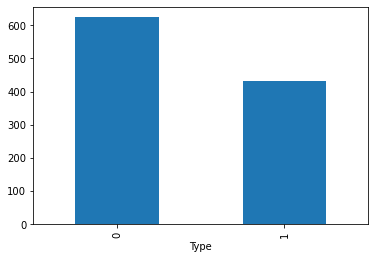

In [18]:
# How many fake and real articles?
print(data.groupby(['Type'])['title'].count())
data.groupby(['Type'])['title'].count().plot(kind="bar")
plt.show()

In [19]:
data['Type'] = data['Type'].astype('category').cat.codes  # Convert type to numeric



In [35]:
unique_values = data['title'].value_counts()[data['title'].value_counts() == 1]
first_unique_value = unique_values.index[0] if not unique_values.empty else None

first_unique_value

'washington post breaking news world us dc news  analysis'

In [20]:
#check the dtypes

data.dtypes

news_url     object
title        object
tweet_ids    object
Type           int8
dtype: object

In [21]:
# Text preprocessing (tokenization)
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(data['title'])
sequences = tokenizer.texts_to_sequences(data['title'])
padded_sequences = pad_sequences(sequences, maxlen=100, padding='post')

# User feature engineering (simple example: extract count of tweet_ids)
data['tweet_count'] = data['tweet_ids'].apply(lambda x: len(str(x).split(',')))


In [22]:
# Combine textual and user features
X_text = padded_sequences
X_user = data[['tweet_count']].values
X = np.hstack((X_text, X_user))  # Combine features
y = data['Type'].values


In [23]:
# Handle class imbalance with SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

In [24]:
# Define LSTM and CNN model
input_text = Input(shape=(100,))
embedding = Embedding(input_dim=10000, output_dim=128, input_length=100)(input_text)
lstm = LSTM(64, return_sequences=True)(embedding)
cnn = Conv1D(64, kernel_size=3, activation='relu')(lstm)
pooling = GlobalMaxPooling1D()(cnn)
dense_text = Dense(64, activation='relu')(pooling)

input_user = Input(shape=(1,))
dense_user = Dense(16, activation='relu')(input_user)


In [30]:
def predict(news_title, tweet_count):
    # Preprocess the input text
    sequences = tokenizer.texts_to_sequences([news_title])
    padded_sequence = pad_sequences(sequences, maxlen=100, padding="post")

    # Extract features using the LSTM-CNN model
    lstm_cnn_features = lstm_cnn_model.predict([padded_sequence, np.array([tweet_count])])

    # Debug: Print the shape of LSTM-CNN features
    print(f"LSTM-CNN Features Shape: {lstm_cnn_features.shape}")

    # Ensure the output has the correct shape for RandomForestClassifier
    if lstm_cnn_features.shape[1] != 80:
        print("Warning: Feature mismatch! Reshaping the output.")
        # Reshape to have 80 features (if needed)
        lstm_cnn_features = lstm_cnn_features.reshape(1, 80)  # Adjust this to your model's output

    # Debug: Print the shape after reshaping (if needed)
    print(f"Reshaped Features Shape: {lstm_cnn_features.shape}")

    # Make predictions using the Random Forest model
    prediction = rf_model.predict(lstm_cnn_features)

    return "Fake News" if prediction[0] == 1 else "Real News"


In [25]:
# Combine text and user features
combined = Concatenate()([dense_text, dense_user])
dropout = Dropout(0.5)(combined)
final_dense = Dense(32, activation='relu')(dropout)

# Output layer
output = Dense(1, activation='sigmoid')(final_dense)

# Create the model
model = Model(inputs=[input_text, input_user], outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit([X_train[:, :-1], X_train[:, -1]], y_train, epochs=10, batch_size=32, validation_split=0.2)

# Extract features from trained LSTM+CNN for Random Forest
intermediate_model = Model(inputs=model.input, outputs=combined)
X_train_features = intermediate_model.predict([X_train[:, :-1], X_train[:, -1]])
X_test_features = intermediate_model.predict([X_test[:, :-1], X_test[:, -1]])

# Train Random Forest on extracted features
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_features, y_train)

# Evaluate the model
y_pred = rf.predict(X_test_features)
print(classification_report(y_test, y_pred))

Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - accuracy: 0.4697 - loss: 0.7067 - val_accuracy: 0.5500 - val_loss: 0.6906
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.5811 - loss: 0.6842 - val_accuracy: 0.7700 - val_loss: 0.6050
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.8476 - loss: 0.5772 - val_accuracy: 0.7900 - val_loss: 0.5508
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.9596 - loss: 0.2001 - val_accuracy: 0.8100 - val_loss: 0.5849
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.9476 - loss: 0.1938 - val_accuracy: 0.7950 - val_loss: 0.5380
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.9789 - loss: 0.0957 - val_accuracy: 0.7900 - val_loss: 0.6952
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.9884 - loss: 0.0429 - val_accuracy: 0.7900 - val_loss: 0.8093
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.9904 - loss: 0.0439 - val_accuracy: 0.7950 - v

In [26]:

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Print the results
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(conf_matrix)

print("Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.74      0.80       128
           1       0.76      0.88      0.82       122

    accuracy                           0.81       250
   macro avg       0.81      0.81      0.81       250
weighted avg       0.82      0.81      0.81       250

Confusion Matrix:
[[ 95  33]
 [ 15 107]]
Metrics:
Accuracy: 0.8080
Precision: 0.7643
Recall: 0.8770
F1 Score: 0.8168


In [27]:
model.save("lstm_cnn_model.h5")
print("Model saved as lstm_cnn_model.h5")

Model saved as lstm_cnn_model.h5


In [28]:
with open("tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)

In [29]:

with open("rf.pkl",'wb') as file:
    pickle.dump(rf, file)

In [37]:
from tensorflow.keras.models import load_model

# Load the saved model
lstm_cnn_model = load_model("lstm_cnn_model.h5")


In [39]:
from tensorflow.keras.models import load_model
import pickle
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Load the saved LSTM-CNN model
lstm_cnn_model = load_model("lstm_cnn_model.h5")

# Load the saved tokenizer
with open("tokenizer.pkl", "rb") as f:
    tokenizer = pickle.load(f)

# Sample inputs for prediction
news_title = "Breaking news: Major event happening right now"
tweet_count = 50

# Tokenize and preprocess the text input
sequences = tokenizer.texts_to_sequences([news_title])
padded_sequence = pad_sequences(sequences, maxlen=100, padding='post')

# Get features from the LSTM-CNN model
lstm_cnn_features = lstm_cnn_model.predict([padded_sequence, np.array([tweet_count])])
print(f"LSTM-CNN Features Shape: {lstm_cnn_features.shape}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
LSTM-CNN Features Shape: (1, 1)


In [42]:
# Adjust the final dense layer to output 80 features
final_dense = Dense(80, activation='relu')(dropout)  # Change to 80 features


In [43]:
from tensorflow.keras.models import load_model
import pickle

# Load the LSTM-CNN model
lstm_cnn_model = load_model("lstm_cnn_model.h5")
print("LSTM-CNN Model loaded.")

# Load the Random Forest model
with open("rf.pkl", "rb") as f:
    rf_model = pickle.load(f)
print("Random Forest Model loaded.")


LSTM-CNN Model loaded.
Random Forest Model loaded.


In [44]:
# Example inputs for prediction
news_title = "Breaking news: Major event happening right now"
tweet_count = 50

# Tokenize and preprocess the text input
sequences = tokenizer.texts_to_sequences([news_title])
padded_sequence = pad_sequences(sequences, maxlen=100, padding='post')

# Get features from the LSTM-CNN model
lstm_cnn_features = lstm_cnn_model.predict([padded_sequence, np.array([tweet_count])])

# Print the LSTM-CNN features shape for debugging
print(f"LSTM-CNN Features Shape: {lstm_cnn_features.shape}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
LSTM-CNN Features Shape: (1, 1)


In [46]:
# Final dense layer with 80 units
final_dense = Dense(80, activation='relu')(dropout)

# Output layer
output = Dense(1, activation='sigmoid')(final_dense)

# Create the model
model = Model(inputs=[input_text, input_user], outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [47]:
model.fit([X_train[:, :-1], X_train[:, -1]], y_train, epochs=10, batch_size=32, validation_split=0.2)


Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - accuracy: 0.8703 - loss: 0.2851 - val_accuracy: 0.7950 - val_loss: 1.2480
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.9943 - loss: 0.0296 - val_accuracy: 0.8050 - val_loss: 1.3239
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.9966 - loss: 0.0106 - val_accuracy: 0.8000 - val_loss: 1.6225
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.9983 - loss: 0.0075 - val_accuracy: 0.7900 - val_loss: 1.9259
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.9988 - loss: 0.0051 - val_accuracy: 0.7950 - val_loss: 2.1408
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.9997 - loss: 0.0023 - val_accuracy: 0.7950 - val_loss: 2.3135
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.9996 - loss: 0.0021 - val_accuracy: 0.7950 - val_loss: 2.5148
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.9990 - loss: 0.0031 - val_accuracy: 0.8000 - v

In [48]:
# Extract features from the trained LSTM-CNN model
intermediate_model = Model(inputs=model.input, outputs=combined)
X_train_features = intermediate_model.predict([X_train[:, :-1], X_train[:, -1]])
X_test_features = intermediate_model.predict([X_test[:, :-1], X_test[:, -1]])


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


In [50]:
import tensorflow as tf

# Use @tf.function to optimize prediction function
@tf.function(reduce_retracing=True)
def predict_function(inputs):
    return model(inputs)


In [51]:
# Assuming you have the new training data in X_train and y_train
model.fit([X_train[:, :-1], X_train[:, -1]], y_train, epochs=10, batch_size=32, validation_split=0.2)


Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.9981 - loss: 0.0026 - val_accuracy: 0.7950 - val_loss: 2.4755
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.9994 - loss: 0.0023 - val_accuracy: 0.7950 - val_loss: 2.3270
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.9988 - loss: 0.0032 - val_accuracy: 0.7950 - val_loss: 2.5182
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.9994 - loss: 0.0030 - val_accuracy: 0.7950 - val_loss: 2.7437
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.9996 - loss: 0.0017 - val_accuracy: 0.7950 - val_loss: 2.8651
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.9993 - loss: 0.0034 - val_accuracy: 0.7950 - val_loss: 2.9537
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.9983 - loss: 0.0030 - val_accuracy: 0.7950 - val_loss: 3.0651
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.9988 - loss: 0.0024 - val_accuracy: 0.8000 - v

In [52]:
# Save the model
model.save("lstm_cnn_model.h5")

# Save the tokenizer
with open("tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)


In [53]:
model.save("lstm_cnn_model.keras")


In [54]:
from tensorflow.keras.models import load_model

# Load the saved model
model = load_model("lstm_cnn_model.keras")


In [55]:
loss, accuracy = model.evaluate([X_test[:, :-1], X_test[:, -1]], y_test)
print(f"Test Accuracy: {accuracy}")



8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.8118 - loss: 3.6134
Test Accuracy: 0.8159999847412109


In [56]:
new_input_text = "Breaking news: Major event happening right now"
new_input_tweet_count = 50

# Tokenize and pad the text input
sequences = tokenizer.texts_to_sequences([new_input_text])
padded_sequence = pad_sequences(sequences, maxlen=100, padding="post")

# Convert tweet count to a numpy array
tweet_count_array = np.array([new_input_tweet_count])

# Make prediction using the model
prediction = model.predict([padded_sequence, tweet_count_array])

# Output the prediction
print(f"Prediction: {prediction}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step
Prediction: [[1.]]
